In [ ]:
!pip install lifelines scikit-survival shap imbalanced-learn --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.formula.api as smf


import shap

sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

In [ ]:
df = pd.read_csv("Ovarian_patient_data.csv")

print("Formato:", df.shape)
print("\nColunas:")
print(df.columns.tolist())

df.head()


Formato: (200100, 34)

Colunas:
['Timestamp', 'Age', 'BMI', 'Comorbidity', 'Symptom', 'CA125', 'CancerStage', 'Histopathology', 'PreviousTreatment', 'MenstrualHistory', 'Ethnicity', 'Smoking', 'Alcohol', 'Residence', 'SocioeconomicStatus', 'BRCA_Mutation', 'GeneExpression', 'SNP_Status', 'DNAMethylation', 'miRNA', 'TumorSize', 'TumorLocation', 'EnhancementPattern', 'RadiomicTexture', 'RadiomicIntensity', 'RadiomicShape', 'DopplerVelocity', 'Parity', 'OralContraceptives', 'HormoneTherapy', 'MenarcheAge', 'MenopauseAge', 'RiskLabel', 'ProgressionProbability']


,Timestamp,Age,BMI,Comorbidity,Symptom,CA125,CancerStage,Histopathology,PreviousTreatment,MenstrualHistory,...,RadiomicIntensity,RadiomicShape,DopplerVelocity,Parity,OralContraceptives,HormoneTherapy,MenarcheAge,MenopauseAge,RiskLabel,ProgressionProbability
0,2019-01-01 00:00:00,67.450712,27.468755,0,0,66.738329,0,serous,0,regular,...,57.572038,1.285647,1.948916,0,0,0,12.077803,54.947593,2,0.176654
1,2019-01-01 01:00:00,57.926035,27.736019,1,0,28.390526,1,clear cell,0,regular,...,44.385558,0.656970,3.589821,0,0,0,12.745908,46.864164,0,0.343371
2,2019-01-01 02:00:00,69.715328,22.285561,0,0,118.120787,3,clear cell,1,regular,...,35.711312,1.034179,3.625658,0,0,0,12.495603,55.757130,0,0.036907
3,2019-01-01 03:00:00,82.845448,31.315519,1,1,6.418598,0,serous,1,regular,...,49.922109,1.000078,1.108221,0,0,0,12.577276,50.462495,1,0.161943
4,2019-01-01 04:00:00,56.487699,17.056296,1,0,65.912779,1,mucinous,0,regular,...,43.547336,1.415819,1.030482,2,0,0,14.698884,58.628299,0,0.554210


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Timestamp               200100 non-null  object 
 1   Age                     200100 non-null  float64
 2   BMI                     200100 non-null  float64
 3   Comorbidity             200100 non-null  int64  
 4   Symptom                 200100 non-null  int64  
 5   CA125                   200100 non-null  float64
 6   CancerStage             200100 non-null  int64  
 7   Histopathology          200100 non-null  object 
 8   PreviousTreatment       200100 non-null  int64  
 9   MenstrualHistory        200100 non-null  object 
 10  Ethnicity               200100 non-null  object 
 11  Smoking                 200100 non-null  int64  
 12  Alcohol                 200100 non-null  int64  
 13  Residence               200100 non-null  object 
 14  SocioeconomicStatus 

In [ ]:
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Valores ausentes por coluna:
Timestamp                 0
Age                       0
BMI                       0
Comorbidity               0
Symptom                   0
CA125                     0
CancerStage               0
Histopathology            0
PreviousTreatment         0
MenstrualHistory          0
Ethnicity                 0
Smoking                   0
Alcohol                   0
Residence                 0
SocioeconomicStatus       0
BRCA_Mutation             0
GeneExpression            0
SNP_Status                0
DNAMethylation            0
miRNA                     0
TumorSize                 0
TumorLocation             0
EnhancementPattern        0
RadiomicTexture           0
RadiomicIntensity         0
RadiomicShape             0
DopplerVelocity           0
Parity                    0
OralContraceptives        0
HormoneTherapy            0
MenarcheAge               0
MenopauseAge              0
RiskLabel                 0
ProgressionProbability    0
dtype: int64


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200100.0,59.901575,14.668235,1.800000e+01,49.891372,60.025998,70.141600,90.000000
BMI,200100.0,28.003226,4.980700,1.500000e+01,24.616558,27.998428,31.361152,49.096832
Comorbidity,200100.0,0.300000,0.458259,0.000000e+00,0.000000,0.000000,1.000000,1.000000
Symptom,200100.0,0.402384,0.490380,0.000000e+00,0.000000,0.000000,1.000000,1.000000
CA125,200100.0,34.874555,34.411115,1.770624e-05,10.057735,24.162441,48.421526,200.000000
CancerStage,200100.0,0.996067,1.223703,0.000000e+00,0.000000,0.000000,2.000000,4.000000
PreviousTreatment,200100.0,0.199530,0.399648,0.000000e+00,0.000000,0.000000,0.000000,1.000000
Smoking,200100.0,0.199825,0.399870,0.000000e+00,0.000000,0.000000,0.000000,1.000000
Alcohol,200100.0,0.250855,0.433506,0.000000e+00,0.000000,0.000000,1.000000,1.000000
BRCA_Mutation,200100.0,0.150025,0.357097,0.000000e+00,0.000000,0.000000,0.000000,1.000000


In [ ]:
categoricas = ['BRCA_Mutation','SNP_Status','Smoking','Alcohol','OralContraceptives','HormoneTherapy','Parity','RiskLabel']
for col in categoricas:
    print(f"\nDistribuição de {col}:")
    print(df[col].value_counts(normalize=True).round(3))


Distribuição de BRCA_Mutation:
BRCA_Mutation
0    0.85
1    0.15
Name: proportion, dtype: float64

Distribuição de SNP_Status:
SNP_Status
0    0.9
1    0.1
Name: proportion, dtype: float64

Distribuição de Smoking:
Smoking
0    0.8
1    0.2
Name: proportion, dtype: float64

Distribuição de Alcohol:
Alcohol
0    0.749
1    0.251
Name: proportion, dtype: float64

Distribuição de OralContraceptives:
OralContraceptives
0    0.8
1    0.2
Name: proportion, dtype: float64

Distribuição de HormoneTherapy:
HormoneTherapy
0    0.851
1    0.149
Name: proportion, dtype: float64

Distribuição de Parity:
Parity
0    0.598
1    0.201
2    0.150
3    0.051
Name: proportion, dtype: float64

Distribuição de RiskLabel:
RiskLabel
0    0.60
1    0.20
2    0.15
3    0.05
Name: proportion, dtype: float64


/tmp/ipython-input-1604022845.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="RiskLabel", data=df, palette="viridis")


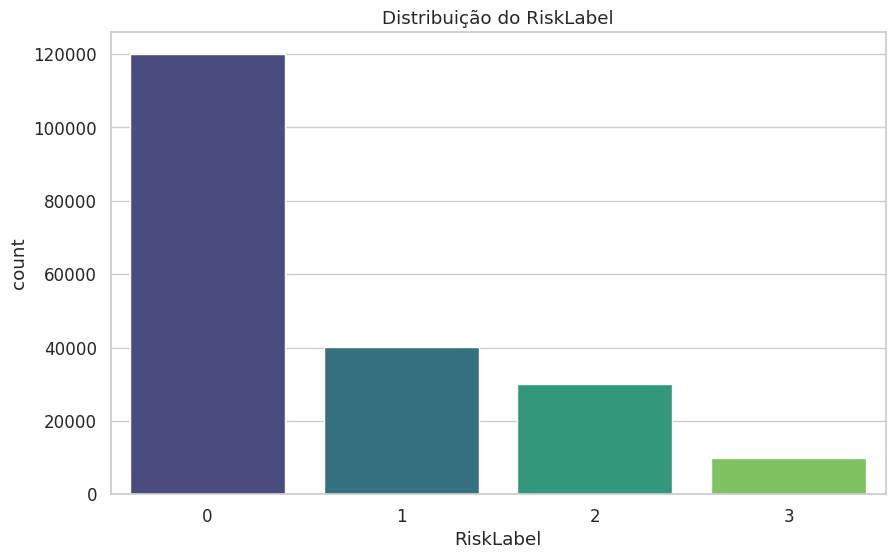

In [ ]:
sns.countplot(x="RiskLabel", data=df, palette="viridis")
plt.title("Distribuição do RiskLabel")
plt.show()

In [ ]:
cols_interesse = [
    'BRCA_Mutation','SNP_Status','Smoking','Alcohol',
    'OralContraceptives','HormoneTherapy','Parity',
    'Age','BMI','Comorbidity',
    'RiskLabel','ProgressionProbability'
]

df_sub = df[cols_interesse].copy()

print("Formato do subconjunto:", df_sub.shape)
df_sub.head()

Formato do subconjunto: (200100, 12)


,BRCA_Mutation,SNP_Status,Smoking,Alcohol,OralContraceptives,HormoneTherapy,Parity,Age,BMI,Comorbidity,RiskLabel,ProgressionProbability
0,1,0,0,0,0,0,0,67.450712,27.468755,0,2,0.176654
1,0,1,0,0,0,0,0,57.926035,27.736019,1,0,0.343371
2,0,0,0,0,0,0,0,69.715328,22.285561,0,0,0.036907
3,0,0,0,0,0,0,0,82.845448,31.315519,1,1,0.161943
4,0,0,0,1,0,0,2,56.487699,17.056296,1,0,0.554210


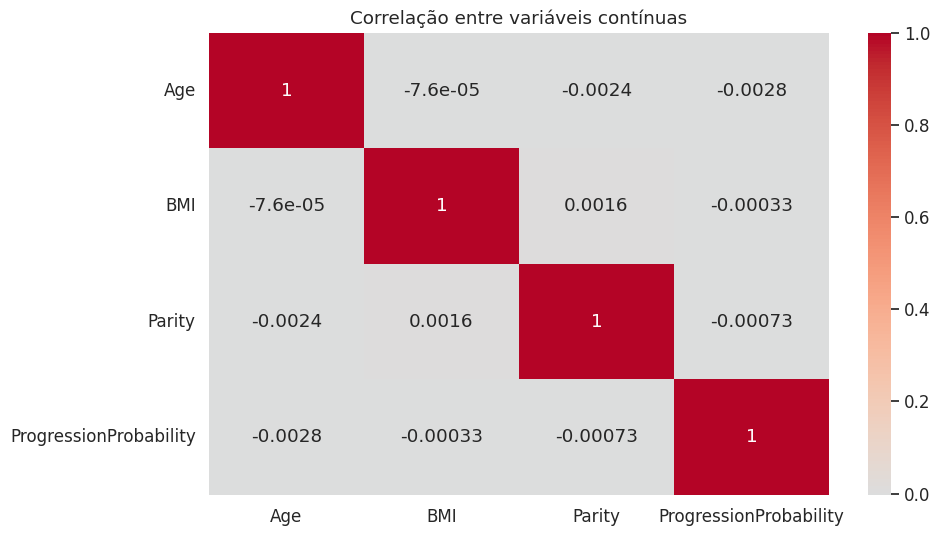

In [ ]:
cont_vars = ['Age','BMI','Parity','ProgressionProbability']
corr = df_sub[cont_vars].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlação entre variáveis contínuas")
plt.show()

In [ ]:
for factor in ['Smoking','Alcohol','OralContraceptives','HormoneTherapy']:
    tab = pd.crosstab(df_sub['BRCA_Mutation'], df_sub[factor], normalize='index')
    print(f"\nBRCA vs {factor} (proporção dentro de cada grupo BRCA):")
    print(tab.round(3))



BRCA vs Smoking (proporção dentro de cada grupo BRCA):
Smoking            0      1
BRCA_Mutation              
0              0.800  0.200
1              0.799  0.201

BRCA vs Alcohol (proporção dentro de cada grupo BRCA):
Alcohol            0      1
BRCA_Mutation              
0              0.749  0.251
1              0.748  0.252

BRCA vs OralContraceptives (proporção dentro de cada grupo BRCA):
OralContraceptives      0      1
BRCA_Mutation                   
0                   0.800  0.200
1                   0.799  0.201

BRCA vs HormoneTherapy (proporção dentro de cada grupo BRCA):
HormoneTherapy      0      1
BRCA_Mutation               
0               0.851  0.149
1               0.851  0.149


In [ ]:
X = df_sub.drop(columns=['RiskLabel','ProgressionProbability'])
y = df_sub['RiskLabel']

X['BRCA_Smoking'] = X['BRCA_Mutation'] * X['Smoking']
X['BRCA_Alcohol'] = X['BRCA_Mutation'] * X['Alcohol']
X['BRCA_OC'] = X['BRCA_Mutation'] * X['OralContraceptives']
X['BRCA_HT'] = X['BRCA_Mutation'] * X['HormoneTherapy']

X['SNP_Smoking'] = X['SNP_Status'] * X['Smoking']
X['SNP_Alcohol'] = X['SNP_Status'] * X['Alcohol']

scaler = StandardScaler()
X[['Age','BMI','Parity']] = scaler.fit_transform(X[['Age','BMI','Parity']])

print("Shape final de X:", X.shape)
X.head()

Shape final de X: (200100, 16)


,BRCA_Mutation,SNP_Status,Smoking,Alcohol,OralContraceptives,HormoneTherapy,Parity,Age,BMI,Comorbidity,BRCA_Smoking,BRCA_Alcohol,BRCA_OC,BRCA_HT,SNP_Smoking,SNP_Alcohol
0,1,0,0,0,0,0,-0.716292,0.514660,-0.107309,0,0,0,0,0,0,0
1,0,1,0,0,0,0,-0.716292,-0.134682,-0.053649,1,0,0,0,0,0,0
2,0,0,0,0,0,0,-0.716292,0.669050,-1.147967,0,0,0,0,0,0,0
3,0,0,0,0,0,0,-0.716292,1.564192,0.665027,1,0,0,0,0,0,0
4,0,0,0,1,0,0,1.476908,-0.232740,-2.197875,1,0,0,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

coef_df = pd.DataFrame(log_reg.coef_.T, index=X.columns, columns=[f"Classe {i}" for i in range(len(log_reg.classes_))])
print("\nCoeficientes (efeito log-odds):")
print(coef_df.round(3).head(15))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.60      1.00      0.75     35990
           1       0.00      0.00      0.00     12028
           2       0.00      0.00      0.00      9020
           3       0.00      0.00      0.00      2992

    accuracy                           0.60     60030
   macro avg       0.15      0.25      0.19     60030
weighted avg       0.36      0.60      0.45     60030


Coeficientes (efeito log-odds):
                    Classe 0  Classe 1  Classe 2  Classe 3
BRCA_Mutation         -0.004    -0.006    -0.012     0.021
SNP_Status             0.006     0.044     0.014    -0.064
Smoking                0.008     0.005     0.021    -0.034
Alcohol               -0.002     0.024    -0.004    -0.018
OralContraceptives    -0.010     0.013    -0.005     0.002
HormoneTherapy         0.018    -0.018     0.003    -0.003
Parity                 0.003     0.004    -0.005    -0.002
Age                   -0.001    -0.007    -0.004     0.012
B

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("Formato após SMOTE:", X_res.shape)
print("Distribuição das classes após balanceamento:")
print(pd.Series(y_res).value_counts())

Formato após SMOTE: (335900, 16)
Distribuição das classes após balanceamento:
RiskLabel
2    83975
1    83975
0    83975
3    83975
Name: count, dtype: int64


In [ ]:
log_reg_bal = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
log_reg_bal.fit(X_res, y_res)

y_pred_bal = log_reg_bal.predict(X_test)
print(classification_report(y_test, y_pred_bal, zero_division=0))

coef_df_bal = pd.DataFrame(
    log_reg_bal.coef_.T,
    index=X.columns,
    columns=[f"Classe {i}" for i in range(len(log_reg_bal.classes_))]
)
print("\nCoeficientes com dados balanceados:")
print(coef_df_bal.round(3).head(15))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.60      0.28      0.39     35990
           1       0.20      0.14      0.16     12028
           2       0.14      0.09      0.11      9020
           3       0.05      0.49      0.09      2992

    accuracy                           0.23     60030
   macro avg       0.25      0.25      0.19     60030
weighted avg       0.42      0.23      0.28     60030


Coeficientes com dados balanceados:
                    Classe 0  Classe 1  Classe 2  Classe 3
BRCA_Mutation          0.024     0.025    -0.029    -0.019
SNP_Status             0.110     0.075     0.031    -0.217
Smoking                0.047     0.023     0.027    -0.098
Alcohol                0.033     0.036    -0.001    -0.068
OralContraceptives     0.041     0.011     0.007    -0.059
HormoneTherapy         0.081     0.006     0.024    -0.112
Parity                 0.007     0.009    -0.003    -0.014
Age                   -0.001    -0.005    -0.008     0.0

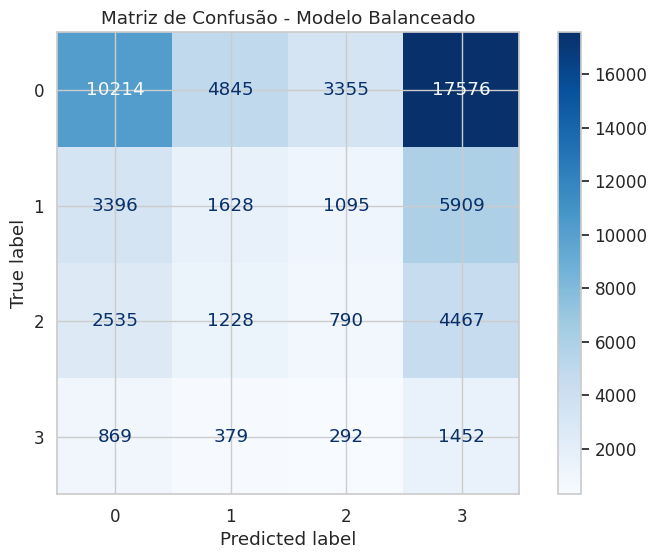

In [ ]:
cm = confusion_matrix(y_test, y_pred_bal, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - Modelo Balanceado")
plt.show()

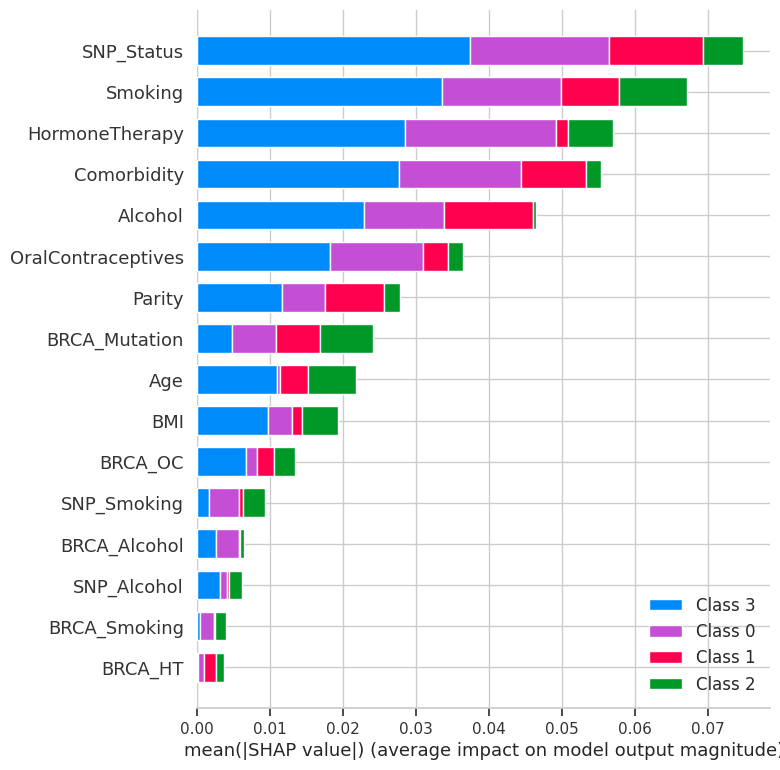

In [ ]:
explainer = shap.Explainer(log_reg_bal, X_res)
shap_values = explainer(X_test)

shap.summary_plot(shap_values.values, X_test, feature_names=X.columns, plot_type="bar")

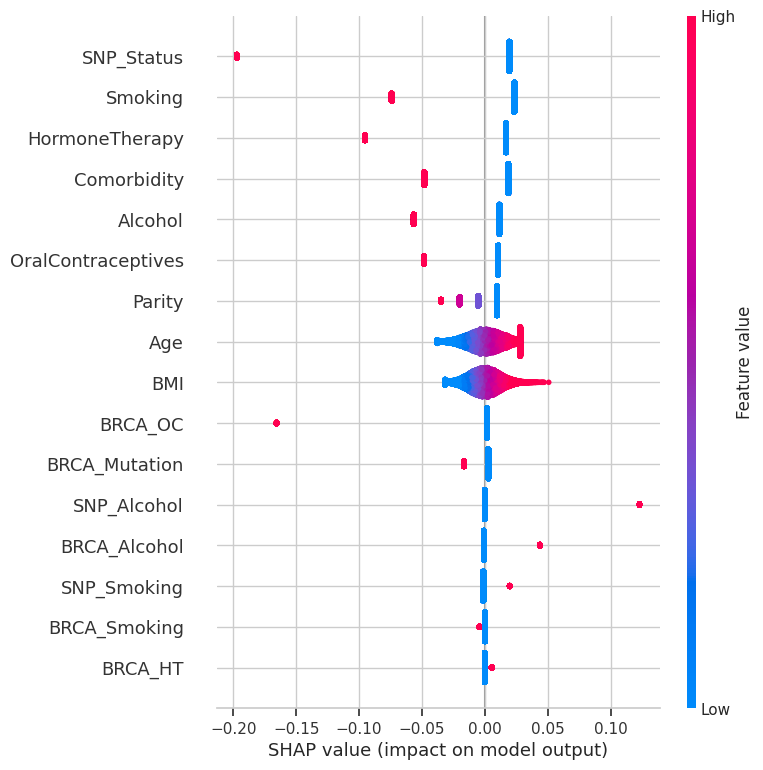

In [ ]:
shap.summary_plot(shap_values[:,:,3], X_test, feature_names=X.columns)

In [ ]:
formula = "RiskLabel ~ BRCA_Mutation*OralContraceptives + BRCA_Mutation*HormoneTherapy + BRCA_Mutation*Smoking + SNP_Status*Smoking + SNP_Status*Alcohol + Age + BMI + Comorbidity + Parity"
model_sm = smf.mnlogit(formula, data=df_sub)
result = model_sm.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 1.063045
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:              RiskLabel   No. Observations:               200100
Model:                        MNLogit   Df Residuals:                   200052
Method:                           MLE   Df Model:                           45
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:               7.714e-05
Time:                        04:44:57   Log-Likelihood:            -2.1272e+05
converged:                       True   LL-Null:                   -2.1273e+05
Covariance Type:            nonrobust   LLR p-value:                    0.9115
                     RiskLabel=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.0925      0.041    -26.34

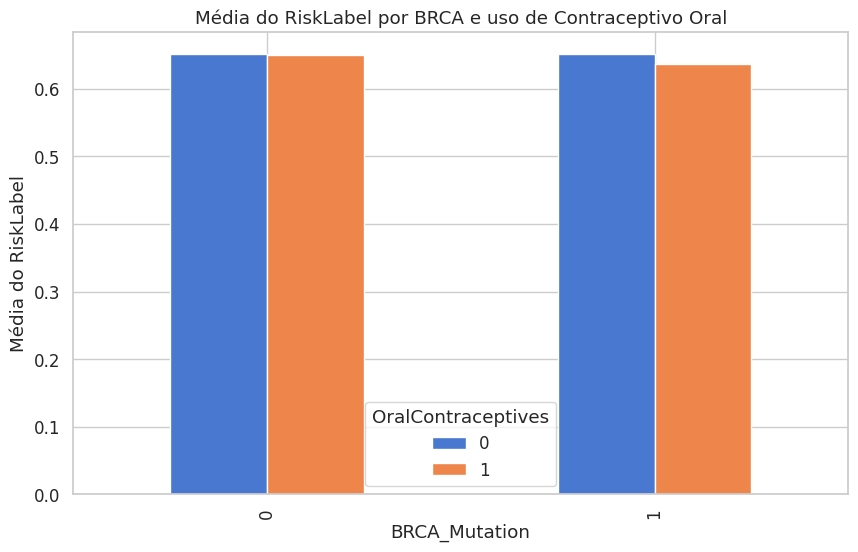

In [ ]:
pd.crosstab(df_sub['BRCA_Mutation'], df_sub['OralContraceptives'], values=df_sub['RiskLabel'], aggfunc='mean').plot(kind='bar')
plt.title("Média do RiskLabel por BRCA e uso de Contraceptivo Oral")
plt.ylabel("Média do RiskLabel")
plt.show()

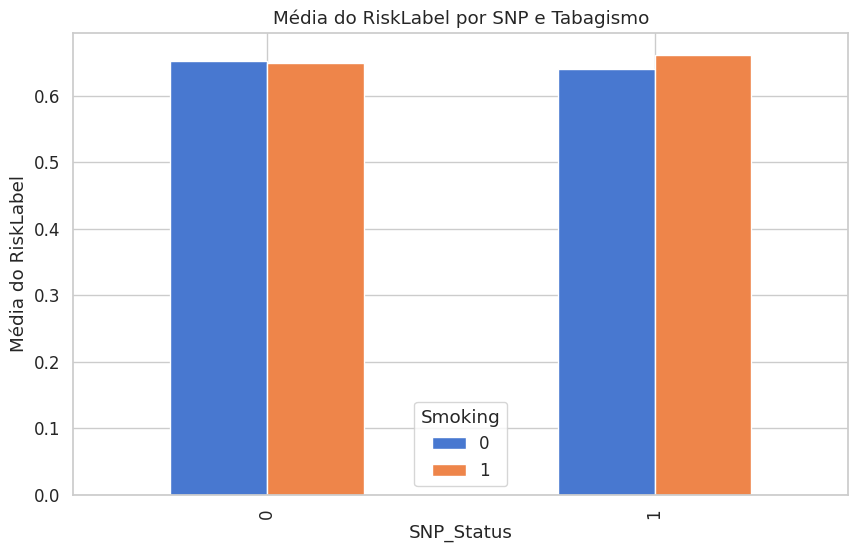

In [ ]:
pd.crosstab(df_sub['SNP_Status'], df_sub['Smoking'], values=df_sub['RiskLabel'], aggfunc='mean').plot(kind='bar')
plt.title("Média do RiskLabel por SNP e Tabagismo")
plt.ylabel("Média do RiskLabel")
plt.show()


In [ ]:
df_bin = df_sub.copy()
df_bin["HighRisk"] = (df_bin["RiskLabel"] == 3).astype(int)

formula_bin = """
HighRisk ~ BRCA_Mutation*OralContraceptives
        + BRCA_Mutation*HormoneTherapy
        + BRCA_Mutation*Smoking
        + SNP_Status*Smoking
        + SNP_Status*Alcohol
        + Age + BMI + Comorbidity + Parity
"""

logit_res = smf.logit(formula_bin, data=df_bin).fit(disp=False)

params = logit_res.params
conf = logit_res.conf_int()
conf.columns = ["ci_low", "ci_high"]

or_df = pd.DataFrame({
    "OR": np.exp(params),
    "CI95_low": np.exp(conf["ci_low"]),
    "CI95_high": np.exp(conf["ci_high"]),
    "p_value": logit_res.pvalues
}).sort_values("p_value")

interaction_rows = [ix for ix in or_df.index if ":" in ix]
inter_or = or_df.loc[interaction_rows].copy()

print("=== Odds Ratios (HighRisk = Classe 3) — Interações gene–ambiente ===")
display(inter_or.round(3))

print("\nResumo do modelo (linha de comando):")
print(logit_res.summary2().tables[1].loc[interaction_rows].round(4))


=== Odds Ratios (HighRisk = Classe 3) — Interações gene–ambiente ===


,OR,CI95_low,CI95_high,p_value
BRCA_Mutation:OralContraceptives,0.855,0.739,0.990,0.037
BRCA_Mutation:HormoneTherapy,0.946,0.805,1.111,0.497
SNP_Status:Alcohol,0.949,0.810,1.112,0.517
SNP_Status:Smoking,1.049,0.886,1.241,0.580
BRCA_Mutation:Smoking,1.001,0.868,1.154,0.990



Resumo do modelo (linha de comando):
                                   Coef.  Std.Err.       z   P>|z|  [0.025  \
BRCA_Mutation:OralContraceptives -0.1563    0.0748 -2.0904  0.0366 -0.3028   
BRCA_Mutation:HormoneTherapy     -0.0558    0.0822 -0.6787  0.4973 -0.2169   
SNP_Status:Alcohol               -0.0524    0.0808 -0.6480  0.5170 -0.2108   
SNP_Status:Smoking                0.0475    0.0860  0.5530  0.5803 -0.1210   
BRCA_Mutation:Smoking             0.0009    0.0725  0.0122  0.9903 -0.1411   

                                  0.975]  
BRCA_Mutation:OralContraceptives -0.0097  
BRCA_Mutation:HormoneTherapy      0.1053  
SNP_Status:Alcohol                0.1061  
SNP_Status:Smoking                0.2160  
BRCA_Mutation:Smoking             0.1429  


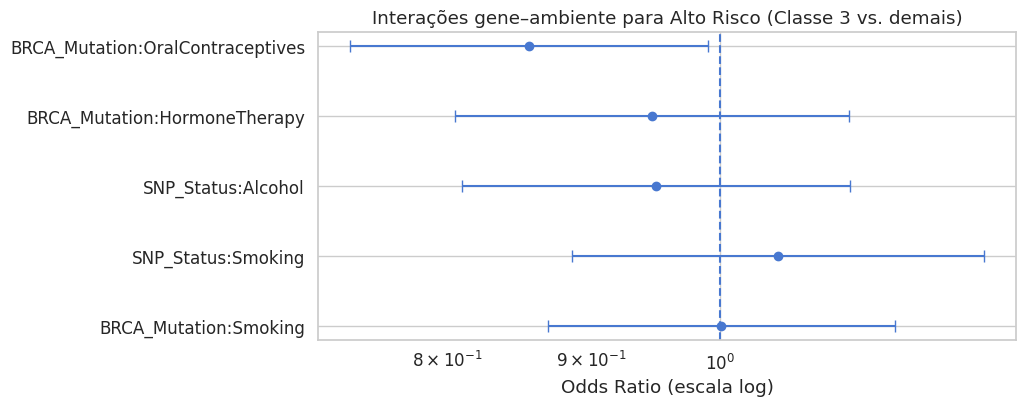

In [ ]:
inter_or_plot = inter_or.sort_values("p_value").copy()

y = np.arange(len(inter_or_plot))
or_vals = inter_or_plot["OR"].values
lo = inter_or_plot["CI95_low"].values
hi = inter_or_plot["CI95_high"].values

xerr_left = np.abs(or_vals - lo)
xerr_right = np.abs(hi - or_vals)
xerr = np.vstack([xerr_left, xerr_right])

plt.figure(figsize=(9, max(4, 0.5*len(inter_or_plot))))
plt.errorbar(or_vals, y, xerr=xerr, fmt='o', capsize=4)
plt.axvline(1.0, linestyle='--')
plt.xscale('log')
plt.yticks(y, inter_or_plot.index)
plt.xlabel("Odds Ratio (escala log)")
plt.title("Interações gene–ambiente para Alto Risco (Classe 3 vs. demais)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
formula_prog = """
ProgressionProbability ~ BRCA_Mutation*OralContraceptives
                     + BRCA_Mutation*HormoneTherapy
                     + BRCA_Mutation*Smoking
                     + SNP_Status*Smoking
                     + SNP_Status*Alcohol
                     + Age + BMI + Comorbidity + Parity
"""

lin_res = smf.ols(formula_prog, data=df_sub).fit()
print(lin_res.summary())

print("\nEfeito BRCA x OralContraceptives na ProgressionProbability:")
print(lin_res.params["BRCA_Mutation:OralContraceptives"])

                              OLS Regression Results                              
Dep. Variable:     ProgressionProbability   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.000
Method:                     Least Squares   F-statistic:                    0.9992
Date:                    Sat, 13 Sep 2025   Prob (F-statistic):              0.452
Time:                            05:08:44   Log-Likelihood:                 82568.
No. Observations:                  200100   AIC:                        -1.651e+05
Df Residuals:                      200084   BIC:                        -1.649e+05
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/tmp/ipython-input-2922362191.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Group_BRCA_OC", y="ProgressionProbability", data=df_sub, palette="Set2")


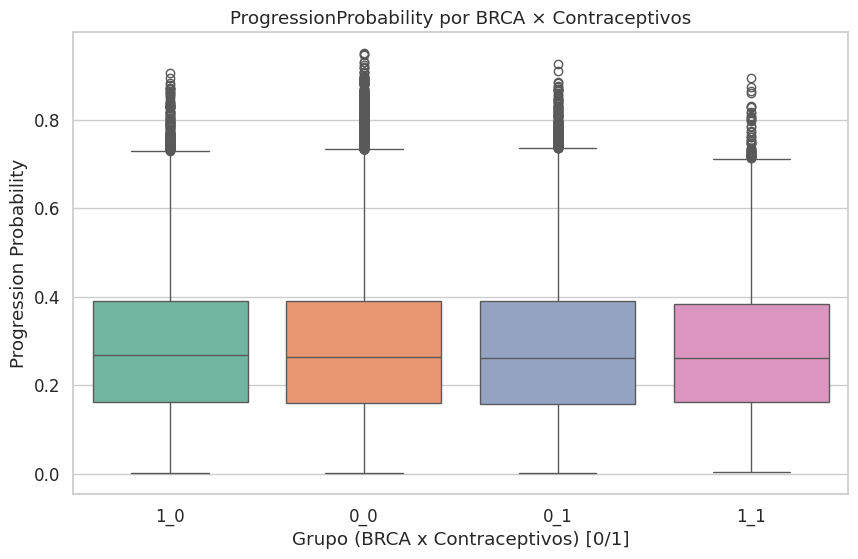

In [ ]:
df_sub["Group_BRCA_OC"] = df_sub["BRCA_Mutation"].astype(str) + "_" + df_sub["OralContraceptives"].astype(str)

sns.boxplot(x="Group_BRCA_OC", y="ProgressionProbability", data=df_sub, palette="Set2")
plt.title("ProgressionProbability por BRCA × Contraceptivos")
plt.xlabel("Grupo (BRCA x Contraceptivos) [0/1]")
plt.ylabel("Progression Probability")
plt.show()


In [ ]:
cenarios = pd.DataFrame({
    "BRCA_Mutation": [0,0,1,1],
    "OralContraceptives": [0,1,0,1],
    "HormoneTherapy": [0,0,0,0],
    "Smoking": [0,0,0,0],
    "SNP_Status": [0,0,0,0],
    "Alcohol": [0,0,0,0],
    "Age": [60,60,60,60],
    "BMI": [28,28,28,28],
    "Comorbidity": [0,0,0,0],
    "Parity": [1,1,1,1]
})

cenarios["Pred_Prob"] = logit_res.predict(cenarios)

print(cenarios)


   BRCA_Mutation  OralContraceptives  HormoneTherapy  Smoking  SNP_Status  \
0              0                   0               0        0           0   
1              0                   1               0        0           0   
2              1                   0               0        0           0   
3              1                   1               0        0           0   

   Alcohol  Age  BMI  Comorbidity  Parity  Pred_Prob  
0        0   60   28            0       1   0.050221  
1        0   60   28            0       1   0.050797  
2        0   60   28            0       1   0.051102  
3        0   60   28            0       1   0.044543  


/tmp/ipython-input-3028650394.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["BRCA- OC-", "BRCA- OC+", "BRCA+ OC-", "BRCA+ OC+"],


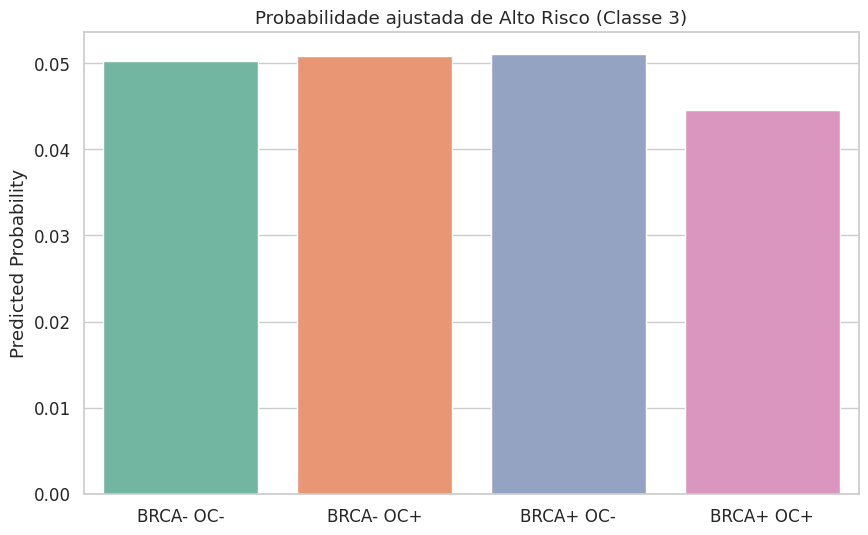

In [ ]:
sns.barplot(x=["BRCA- OC-", "BRCA- OC+", "BRCA+ OC-", "BRCA+ OC+"],
            y=cenarios["Pred_Prob"], palette="Set2")
plt.title("Probabilidade ajustada de Alto Risco (Classe 3)")
plt.ylabel("Predicted Probability")
plt.show()


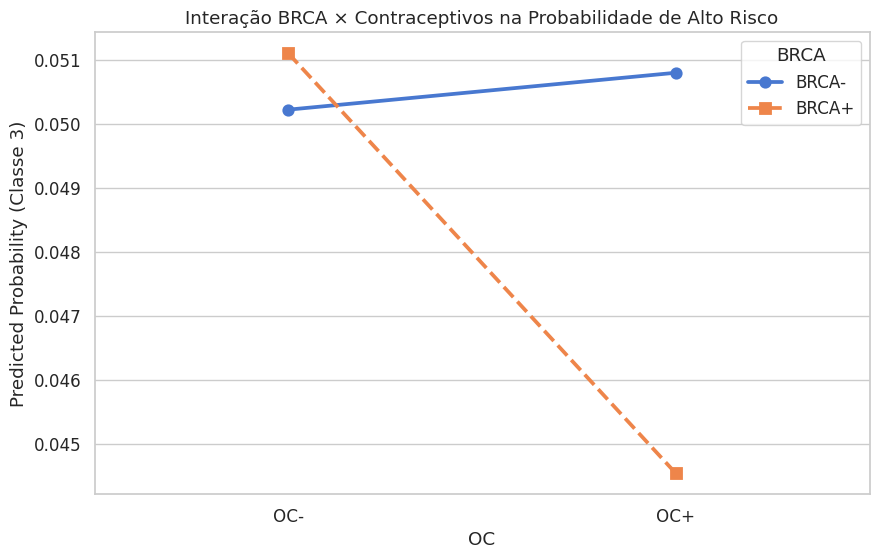

In [ ]:
plot_df = cenarios.copy()
plot_df["BRCA"] = plot_df["BRCA_Mutation"].map({0: "BRCA-", 1: "BRCA+"})
plot_df["OC"] = plot_df["OralContraceptives"].map({0: "OC-", 1: "OC+"})

sns.pointplot(data=plot_df, x="OC", y="Pred_Prob", hue="BRCA", markers=["o","s"], linestyles=["-","--"])
plt.title("Interação BRCA × Contraceptivos na Probabilidade de Alto Risco")
plt.ylabel("Predicted Probability (Classe 3)")
plt.show()


In [ ]:
if "MenopauseAge" not in df_sub.columns:
    df_sub = df_sub.merge(df[["MenopauseAge"]], left_index=True, right_index=True)
df_sub["MenopausalStatus"] = np.where(df_sub["Age"] < df_sub["MenopauseAge"], "Pre", "Post")

print("Distribuição do status menopausal:")
print(df_sub["MenopausalStatus"].value_counts(normalize=True))

Distribuição do status menopausal:
MenopausalStatus
Post    0.737261
Pre     0.262739
Name: proportion, dtype: float64


In [ ]:
results_strat = {}

for status in ["Pre", "Post"]:
    df_group = df_sub[df_sub["MenopausalStatus"] == status]
    df_group["HighRisk"] = (df_group["RiskLabel"] == 3).astype(int)

    formula_strat = """
    HighRisk ~ BRCA_Mutation*OralContraceptives
             + BRCA_Mutation*HormoneTherapy
             + BRCA_Mutation*Smoking
             + SNP_Status*Smoking
             + SNP_Status*Alcohol
             + Age + BMI + Comorbidity + Parity
    """
    model = smf.logit(formula_strat, data=df_group).fit(disp=False)

    coef = model.params["BRCA_Mutation:OralContraceptives"]
    or_val = np.exp(coef)
    ci_low, ci_high = np.exp(model.conf_int().loc["BRCA_Mutation:OralContraceptives"])
    p_val = model.pvalues["BRCA_Mutation:OralContraceptives"]

    results_strat[status] = {
        "OR": or_val,
        "CI95%": f"[{ci_low:.3f} – {ci_high:.3f}]",
        "p_value": p_val
    }

results_strat


/tmp/ipython-input-2171224984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group["HighRisk"] = (df_group["RiskLabel"] == 3).astype(int)
/tmp/ipython-input-2171224984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group["HighRisk"] = (df_group["RiskLabel"] == 3).astype(int)


{'Pre': {'OR': np.float64(0.8671566531792093),
  'CI95%': '[0.645 – 1.166]',
  'p_value': np.float64(0.3452135751788794)},
 'Post': {'OR': np.float64(0.850199457386293),
  'CI95%': '[0.718 – 1.006]',
  'p_value': np.float64(0.0593536682931563)}}

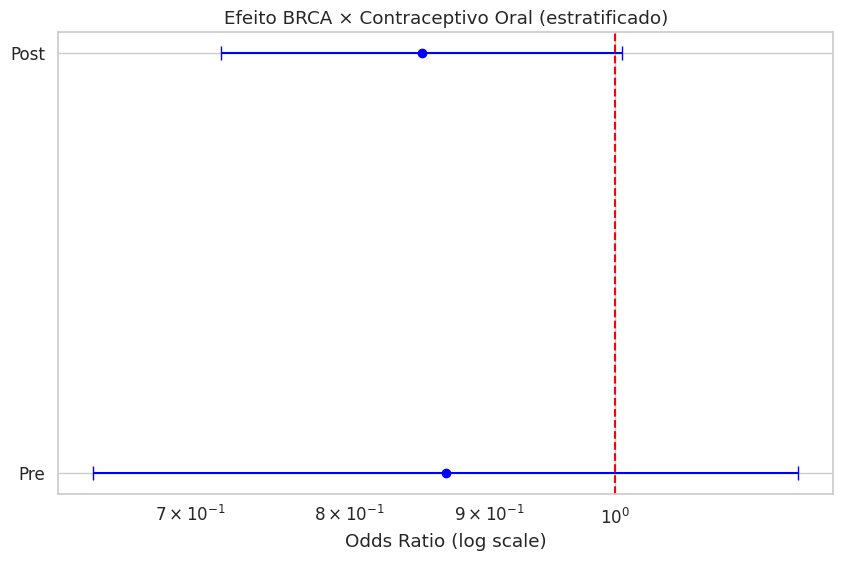

In [ ]:
strat_df = pd.DataFrame(results_strat).T.reset_index()
strat_df.rename(columns={"index": "Status"}, inplace=True)

or_vals = strat_df["OR"].values
ci = strat_df["CI95%"].str.extract(r"\[(.*) – (.*)\]")
ci_low = ci[0].astype(float)
ci_high = ci[1].astype(float)

plt.errorbar(or_vals, strat_df["Status"],
             xerr=[or_vals - ci_low, ci_high - or_vals],
             fmt="o", color="blue", capsize=5)
plt.axvline(1, color="red", linestyle="--")
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Efeito BRCA × Contraceptivo Oral (estratificado)")
plt.show()


In [ ]:
strat_table = pd.DataFrame(results_strat).T
strat_table = strat_table[["OR","CI95%","p_value"]].round(3)
print("Tabela comparativa Pré vs Pós-menopausa:")
display(strat_table)


Tabela comparativa Pré vs Pós-menopausa:


,OR,CI95%,p_value
Pre,0.867157,[0.645 – 1.166],0.345214
Post,0.850199,[0.718 – 1.006],0.059354
